## 1. Importación de módulos

Se importan los módulos necesarios para el funcionamiento del script

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import random
import torchvision
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

## 3. Fijar Hiperparámetros

Los hiperparámetros son valores que se establecen antes del entrenamiento y no se modifican durante el mismo, son identificadores cuyo valor se utiliza para controlar el proceso de aprendizaje, se utilizan para parametrizar el propio proceso de instanciación del modelo. Puedes pensar en ellos como las herramientas utilizadas para describir la configuración del modelo, de esta forma son valores los cuales permiten fijar la forma de entrenamiento y como se llevará a cabo entre otras cosas, en esta celda se definen variables las cuales fungiran como hiperparámetros durante el resto del script


In [ ]:
torch.cuda.get_device_properties


<function torch.cuda.get_device_properties(device: Union[torch.device, str, int]) -> torch._C._CudaDeviceProperties>

In [ ]:
#HIPERPARÁMETROS
#workers = 2

# Tamaño del batch durante el entrenamiento
batch_size = 32

# Tamaño espacial de las imágenes de entrenamiento. Todas las imágenes cambiarán de tamaño a este
#   tamaño usando una transformación
image_size = 64

# Número de canales en las imágenes de entrenamiento. Para imágenes en color, esto es 3
nc = 3

# Tamaño del vector latente z (es decir, tamaño de la entrada del generador)
nz = 100

# Tamaño de los feature maps en el generador
ngf = 64

# Tamaño de los feature maps en el discriminador 
ndf = 64

# Número de épocas de entrenamiento
num_epochs = 1500

# Learning rate para optimizadores
lr = 0.0002

# Hiperparámetro Beta1 para el optimizador ADAM
beta1 = 0.5

# Número de GPU's disponibles, 0 si se usa CPU
ngpu = 1

##4. Usar el dataset

Esta celda nos permite el uso del dataset; una vez descomprimida la carpeta se obtiene su ruta y posteriormente se instancia en ImageFolder, ahí transformamos y normalizamos el dataset para poder ser utilizado.

Operar con grandes conjuntos de datos requiere cargarlos en la memoria de una vez, los programas tienden a ejecutarse lentamente debido a que se cargan conjuntos de datos pesados ​​una vez. PyTorch ofrece una solución para paralelizar el proceso de carga de datos con procesamiento por lotes automático mediante el uso de DataLoader. Se ha utilizado Dataloader para paralelizar la carga de datos, ya que esto aumenta la velocidad y ahorra memoria.

DataLoader reside en el paquete [torch.utils.data.](https://pytorch.org/docs/stable/data.html) Tiene varios parámetros entre los cuales el único argumento obligatorio que se debe pasar es el conjunto de datos que se debe cargar, y el resto son argumentos opcionales.



In [ ]:
data_directory = 'celeba/'
dataset = dset.ImageFolder(root=data_directory,
                           transform=transforms.Compose([
                            transforms.Resize(image_size),
                            transforms.CenterCrop(image_size),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))


dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                        shuffle=True)
#dataloader = torchvision.datasets.CelebA(root: str, split: str = 'train', target_type: Union[List[str], str] = 'attr'
 #                   , transform: Optional[Callable] = None, target_transform: Optional[Callable] = None, download: bool = False)

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

## 5. Muestreo de imagenes de entrenamiento

Esta celda selecciona una muestra del batch del dataset para tener una pre-visualización de las imágenes con las cuales se entrenará el modelo

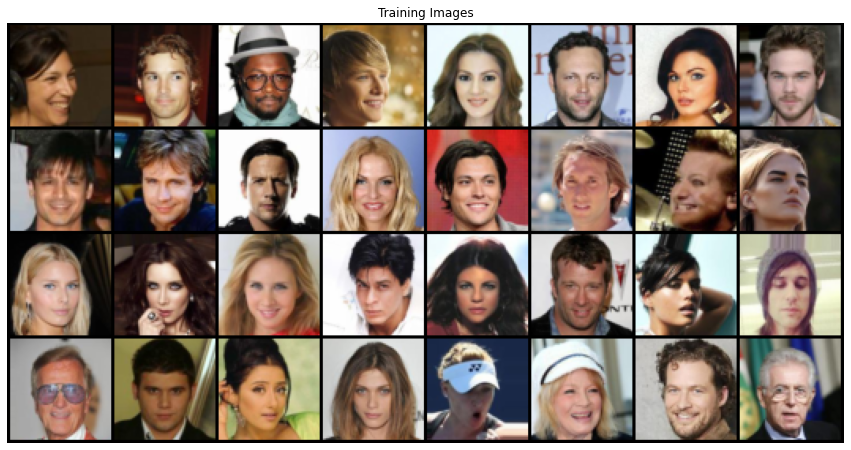

In [ ]:
#Muestreo de imagenes de entrenamiento
real_batch = next(iter(dataloader))
plt.figure(figsize=(15,15))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[0:32], padding=2, normalize=True).cpu(),(1,2,0)))

##6 Inicialización de pesos

Los pesos del modelo se inicializarán aleatoriamente a partir de una distribución normal con media = 0 y desviación estándar = 0,02. La función weights_init toma un modelo inicializado como entrada y reinicializa todas las capas de normalización convolucional, convolucional-transpuesta y por lotes para cumplir con este criterio.

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        

In [ ]:
# Código del Generador

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

##8. Creación del Generador 

Esta celda crea el generador con el hardware que tengamos asignado y posteriormente inicializa los pesos de la red neuronal con la función 'weights_init'

In [ ]:
# Creación del generador
netG = Generator(ngpu).to(device)

# Ultizar multiples GPU's si es necesario
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

#Aplicar la inicialización de pesos con la función 'weights_init'
netG.apply(weights_init)

#Mostrar el modelo
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
#Código del Generador

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

##9. Creación del Discriminador

Esta celda crea el discriminador con el hardware que tengamos asignado y posteriormente inicializa los pesos de la red neuronal con la función 'weights_init'

In [ ]:
#Creación del discriminador
netD = Discriminator(ngpu).to(device)

# Ultizar multiples GPU's si es necesario
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
#Aplicar la inicialización de pesos con la función 'weights_init'
netD.apply(weights_init)

#Mostrar el modelo
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


## 10. Inicializaión de función de pérdida, tensor de vectores latentes, etiquetas y configuración del optimizador ADAM

Se inicializa BCE Loss (Binary Cross Entropy Loss).
La elección de una función de pérdida depende completamente del conjunto de datos, el problema que está tratando de resolver y la variante específica de ese problema. Para problemas de clasificación binaria, la función de pérdida más adecuada se llama BCE. Compara la predicción, que sea un número entre 0 y 1, con el objetivo real, que es 0 o 1. 

Dado a esto tenemos que clasificar las imagenes entre 0 (etiqueta de imagen falsa) y 1 (etiqueta de imagen verdadera).

Por otra parte para el método de optimización usaremos ADAM el cual se inicializa tanto para el Discriminador como el Generador con sus respectivos hiperparametros

In [ ]:
# Inicializar la función BCELoss
criterion = nn.BCELoss()

#Se crea el tensor de vectores latentes que usaremos para visualizar la progresión del generador
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Etiquetas para reales y falsas durante el entrenamiento
real_label = 1.
fake_label = 0.

# Configuración de ADAM para discriminador y generador
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Loop de Entrenamiento
# Listas para el seguimiento del proceso
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Inicio de entrenamiento...")
# Por cada epoca
for epoch in range(num_epochs):
    # Por cada batch en el dataloaer
    for i, data in enumerate(dataloader, 0):

        ## Entrenamiento con todo el batch de imagenes reales
        netD.zero_grad()
        # Formateo del batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass del batch a través del Discriminador
        output = netD(real_cpu).view(-1)
        # Calculo de la pérdida en todo el batch
        errD_real = criterion(output, label)
        # Calculo de gradientes del Discriminador en backward
        errD_real.backward()
        D_x = output.mean().item()

        ##Entrenamiento con todo el batch de imagenes falsas

        # Generación del batch de vectores latentes
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generación del batch de imagenes falsas con el Generador
        fake = netG(noise)
        label.fill_(fake_label)
        # Clasificar el batch de imagenes falsas con el Discriminador
        output = netD(fake.detach()).view(-1)
        # Calculo de la perdida del Discrimador
        errD_fake = criterion(output, label)
        # calculo de gradientes
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Agrega los gradientes del batch de imagenes reales y de imagenes falsas
        errD = errD_real + errD_fake
        # Actualización del Discriminador
        optimizerD.step()

        netG.zero_grad()
        label.fill_(real_label)  # Las etiquetas falsas son reales para el costo del generador
        # Como acabamos de actualizar el Discriminador realice otra pasada hacia
        # adelante del lote totalmente falso a través del Discriminador
        output = netD(fake).view(-1)
        # Calcule la pérdida del Generador en función de esta salida
        errG = criterion(output, label)
        # Calculo de gradientes para del Generador
        errG.backward()
        D_G_z2 = output.mean().item()
        # Actualización del Generador
        optimizerG.step()
        
        # Salidas de estadisticas de entrenamiento
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Guarda las pérdidas del Generador y del Disriminador
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Compruebe cómo le está yendo al generador guardando la salida de G en Fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Inicio de entrenamiento...
[0/1500][0/32]	Loss_D: 1.9637	Loss_G: 4.0723	D(x): 0.3962	D(G(z)): 0.4031 / 0.0193
[1/1500][0/32]	Loss_D: 0.0362	Loss_G: 6.6220	D(x): 0.9711	D(G(z)): 0.0042 / 0.0035
[2/1500][0/32]	Loss_D: 0.0832	Loss_G: 7.4372	D(x): 0.9729	D(G(z)): 0.0478 / 0.0030
[3/1500][0/32]	Loss_D: 0.4925	Loss_G: 11.0490	D(x): 0.8226	D(G(z)): 0.0001 / 0.0001
[4/1500][0/32]	Loss_D: 0.4910	Loss_G: 8.0465	D(x): 0.8466	D(G(z)): 0.0152 / 0.0103
[5/1500][0/32]	Loss_D: 0.0519	Loss_G: 5.0652	D(x): 0.9800	D(G(z)): 0.0281 / 0.0186
[6/1500][0/32]	Loss_D: 0.4753	Loss_G: 7.0611	D(x): 0.9112	D(G(z)): 0.2832 / 0.0017
[7/1500][0/32]	Loss_D: 3.8741	Loss_G: 9.6918	D(x): 0.2149	D(G(z)): 0.0002 / 0.0012
[8/1500][0/32]	Loss_D: 0.1978	Loss_G: 4.4520	D(x): 0.9516	D(G(z)): 0.1267 / 0.0192
[9/1500][0/32]	Loss_D: 0.8722	Loss_G: 8.0461	D(x): 0.9199	D(G(z)): 0.4061 / 0.0012
[10/1500][0/32]	Loss_D: 0.7909	Loss_G: 3.0804	D(x): 0.5706	D(G(z)): 0.0045 / 0.0974
[11/1500][0/32]	Loss_D: 0.2775	Loss_G: 6.1791	D(x): 0.9514

## 12. Visualización de la pérdida durante el entrenamiento

Esta celda muestra una gráfica de como evolucionó la pérdida al transcurrir las iteraciones en el entrenamiento, el objetivo principal en un modelo de aprendizaje es reducir (minimizar) el valor de la función de pérdida con respecto a los parámetros del modelo cambiando los valores del vector de peso a través de diferentes métodos de optimización, como la retropropagación en las redes neuronales.

El valor de pérdida implica qué tan bien o mal se comporta cierto modelo después de cada iteración de optimización. Idealmente, uno esperaría la reducción de la pérdida después de cada o varias iteraciones.

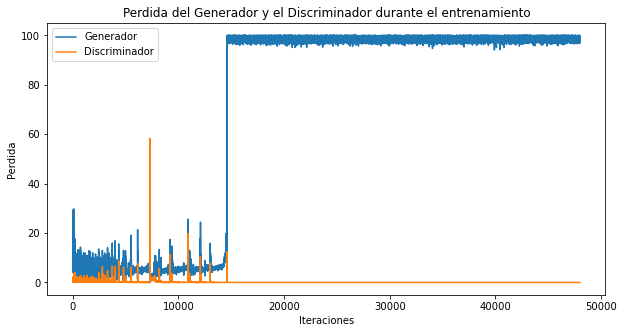

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Perdida del Generador y el Discriminador durante el entrenamiento")
plt.plot(G_losses,label="Generador")
plt.plot(D_losses,label="Discriminador")
plt.xlabel("Iteraciones")
plt.ylabel("Perdida")
plt.legend()
plt.show()

## 13. Captura de la salida

Esta celda muestra como una animación de la evolución de la salida de la red neuronal, como puede notarse al inicio del entrenamiento la red da como salida ruido aleatorio el cuál se va modificando y mostrando una imagen mas parecida a las de entrenamiento, esto concuerda con la teoría.

La calidad de las imágenes entre otras cosas dependerá de la cantidad de épocas que se entrene el modelo.

## Muestra de Imágenes Reales vs Imágenes Falsas

Esta ultima celda genera un plot de un batch real y un batch de imagenes falsas, esto para dar una visualización de las diferencias y/o similitudes entre ambos conjuntos de imágenes.

*   Elemento de la lista
*   Elemento de la lista




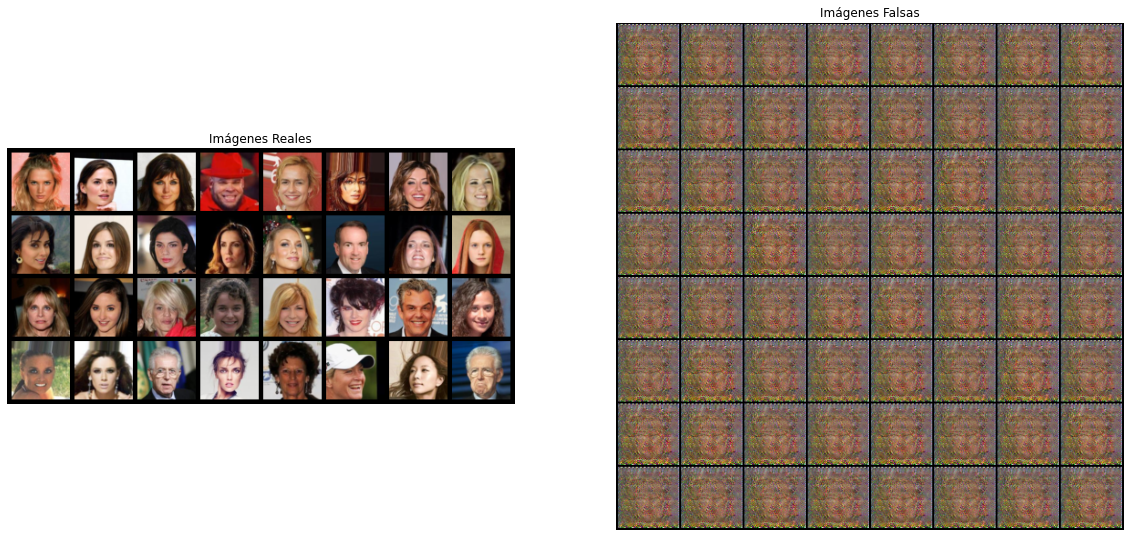

In [ ]:
# Toma un batch de imágenes reales del Dataloader
real_batch = next(iter(dataloader))

# Muestra las imagenes reales
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Imágenes Reales")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Muestra las imagenes fake de la ultima epoca
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Imágenes Falsas")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()